In [1]:
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
import torch
import yaml

sys.path.append("../")
from utils import (
    load_xopt_data,
    get_running_optimum,
    calculate_correlation,
    calculate_mae,
    get_performance_stats,
)

## Compare BO performances

In [2]:
data_dir = "../../data/20231120_LCLS_Injector/"

In [3]:
files_cprior = [
    "nn_optimization_9d_8.yml",
    "nn_optimization_9d_11.yml",
    # "nn_optimization_9d_15.yml",  # worst run
    "nn_optimization_9d_16.yml",
    "nn_optimization_9d_17.yml",
]
files_nnprior = [
    "nn_optimization_9d_12.yml",
    "nn_optimization_9d_13.yml",
    "nn_optimization_9d_14.yml",
    "nn_optimization_9d_18.yml",
    # "nn_optimization_9d_19.yml",  # worst run
]

In [4]:
dfs_cprior = [load_xopt_data(os.path.join(data_dir, file)) for file in files_cprior]
dfs_nnprior = [load_xopt_data(os.path.join(data_dir, file)) for file in files_nnprior]

In [5]:
objective_name, maximize = None, None
for file in files_cprior + files_nnprior:
    with open(os.path.join(data_dir, file)) as f:
        d = yaml.safe_load(f)
        vocs = d["vocs"]
        if objective_name is None:
            objective_name = next(iter(vocs["objectives"]))
        elif not objective_name == next(iter(vocs["objectives"])):
            print(f"Objective name for file {file} doesn't match!")
        if maximize is None:
            maximize = vocs["objectives"][objective_name].upper() == "MAXIMIZE"
        elif not maximize == (vocs["objectives"][objective_name].upper() == "MAXIMIZE"):
            print(f"Objective maximize value for file {file} doesn't match!")

In [6]:
r_cprior = [
    torch.from_numpy(get_running_optimum(df, objective_name, False))
    for df in dfs_cprior
]
r_nnprior = [
    torch.from_numpy(get_running_optimum(df, objective_name, False))
    for df in dfs_nnprior
]

In [7]:
n_init = 3
n_step = 20
start_idx = n_init - 1
steps = torch.arange(0, n_init + n_step - start_idx)

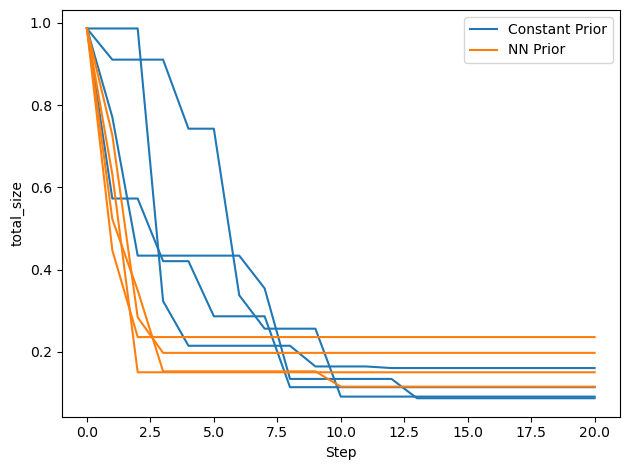

In [8]:
fig, ax = plt.subplots()
for i in range(len(r_cprior)):
    label = "Constant Prior" if i == 0 else ""
    ax.plot(r_cprior[i][start_idx:], "C0-", label=label)
for i in range(len(r_nnprior)):
    label = "NN Prior" if i == 0 else ""
    ax.plot(r_nnprior[i][start_idx:], "C1-", label=label)
ax.set_xlabel("Step")
ax.set_ylabel(objective_name)
ax.legend()
fig.tight_layout()

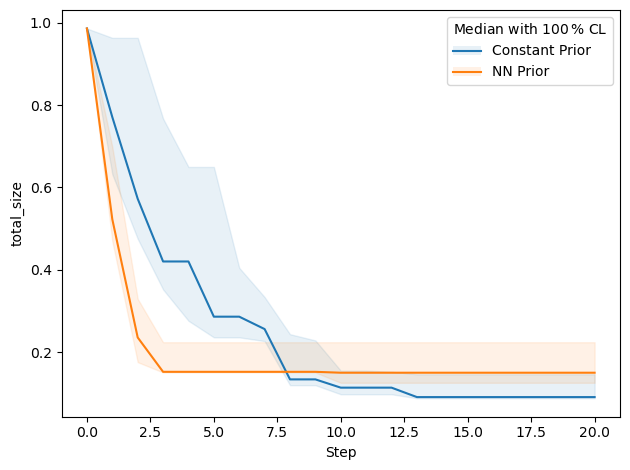

In [9]:
confidence_level = 1.0

fig, ax = plt.subplots()
labels = ["Constant Prior", "NN Prior"]
legend_handles, legend_labels = [], []
for i, r in enumerate([r_cprior, r_nnprior]):
    if r:
        m, lb, ub = get_performance_stats(
            data=torch.stack(r), 
            confidence_level=confidence_level,
        )
        p1 = ax.plot(steps, m[start_idx:], f"C{i}-")
        ax.fill_between(steps, lb[start_idx:], ub[start_idx:], color=f"C{i}", alpha=0.1)
        p2 = ax.fill([], [], facecolor=f"C{i}", alpha=0.1)
        legend_handles.append((p2[0], p1[0]))
        legend_labels.append(labels[i])
ax.legend(legend_handles, legend_labels, loc="upper right", alignment="left", 
          title="Median with {:.0f}$\,$% CL".format(1e2 * confidence_level))
ax.set_xlabel("Step")
ax.set_ylabel(objective_name)
fig.tight_layout()

In [10]:
# # save data to csv
# df = {}
# df["Step"] = steps.numpy()
# for r, label in zip([r_cprior, r_nnprior], ["ConstantPrior", "NNPrior"]):
#     m, lb, ub = get_performance_stats(torch.stack(r), confidence_level=confidence_level)
#     df[f"{label} {int(1e2 * confidence_level)}% LB (mm)"] = lb[start_idx:].numpy()
#     df[f"{label} Median (mm)"] = m[start_idx:].numpy()
#     df[f"{label} {int(1e2 * confidence_level)}% UB (mm)"] = ub[start_idx:].numpy()
# df = pd.DataFrame(df)
# df.to_csv("experimental_data.csv", index=False)

## Model correlation and MAE

In [11]:
data = None
if dfs_nnprior:
    data = pd.concat(dfs_nnprior).dropna(subset=objective_name + "_prior_mean")
    data.drop_duplicates(inplace=True)
data

,QUAD:IN20:121:BCTRL,QUAD:IN20:122:BCTRL,QUAD:IN20:361:BCTRL,QUAD:IN20:371:BCTRL,QUAD:IN20:425:BCTRL,QUAD:IN20:441:BCTRL,QUAD:IN20:511:BCTRL,QUAD:IN20:525:BCTRL,SOLN:IN20:121:BCTRL,Sx,...,bad_measurement_posterior_mean,bad_measurement_posterior_sd,bad_measurement_prior_mean,sigma_xy,total_size,total_size_posterior_mean,total_size_posterior_sd,total_size_prior_mean,xopt_error,xopt_runtime
3,-0.001607,0.000697,-3.172011,3.161794,-2.489160,3.154868,3.428173,-5.068339,0.480109,389.801394,...,0.0,0.014096,0.0,393.893209,0.727067,0.534989,0.318476,0.564193,False,370.424020
4,-0.005365,-0.000148,-3.201611,2.762582,-2.767801,1.403881,3.393735,-3.246505,0.479711,186.488717,...,0.0,0.009920,0.0,227.635907,0.283587,0.515401,0.639404,0.565225,False,104.371466
5,-0.009713,0.002870,-2.249822,1.931504,-2.275894,2.267367,3.013192,-4.799706,0.479471,131.747592,...,0.0,0.008142,0.0,165.326108,0.197197,0.463769,1.128428,0.695698,False,32.875834
6,0.002275,0.001266,-3.271556,3.119537,-2.469564,0.225389,3.277040,-3.019342,0.480577,446.162561,...,0.0,0.007030,0.0,475.426452,0.757366,0.535901,1.279202,0.602786,False,26.748444
7,-0.003916,-0.000545,-2.378075,1.951081,-2.379185,2.072506,5.091303,-5.118846,0.479447,234.317997,...,0.0,0.417262,0.0,246.291330,0.404751,0.372111,1.131659,0.708914,False,127.042861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,0.002816,-0.004955,-3.214886,2.588735,-2.844680,3.060940,5.131240,-5.263280,0.480153,232.005063,...,0.0,0.003589,0.0,239.498255,0.412064,0.467778,0.959643,0.581544,False,48.332323
19,0.003853,-0.003426,-4.318054,3.320028,-3.569125,0.971702,3.733519,-2.923130,0.480982,165.581694,...,0.0,0.003465,0.0,379.419563,0.555220,0.547189,0.974454,0.569843,False,46.927059
20,-0.010018,0.000712,-2.655877,2.970221,-1.155839,2.140000,3.573594,-5.296958,0.479477,434.747952,...,0.0,0.003270,0.0,448.497399,0.773045,-0.131978,0.829148,0.835124,False,30.925798
21,-0.008750,0.002483,-2.218301,2.123940,-2.367070,2.166560,3.601226,-4.975742,0.479513,221.242965,...,0.0,0.003260,0.0,248.918336,0.356092,0.331105,0.814783,0.632623,False,37.030096


In [12]:
metrics = pd.DataFrame(columns=["Correlation", "MAE"])
if dfs_nnprior:
    targets = torch.from_numpy(data[objective_name].values)
    predictions = torch.from_numpy(data[objective_name + "_prior_mean"].values)
    correlation = calculate_correlation(targets, predictions).item()
    mae = calculate_mae(targets, predictions).item()
    metrics.loc[len(metrics.index)] = [correlation, mae]
    metrics.index = ["All Data"]
metrics

,Correlation,MAE
All Data,0.273425,0.254328


In [13]:
run_metrics = pd.DataFrame(columns=["Correlation", "MAE"])
if dfs_nnprior:
    for filename, df in zip(files_nnprior, dfs_nnprior):
        df = df.dropna(subset=[objective_name, objective_name + "_prior_mean"])
        run_targets = torch.from_numpy(df[objective_name].values) 
        run_predictions = torch.from_numpy(df[objective_name + "_prior_mean"].values)
        run_correlation = calculate_correlation(run_predictions, run_targets).item()
        run_mae = calculate_mae(run_predictions, run_targets).item()
        run_metrics.loc[len(run_metrics.index)] = [run_correlation, run_mae]
    run_metrics.index = [os.path.splitext(filename)[0] for filename in files_nnprior]
run_metrics

,Correlation,MAE
nn_optimization_9d_12,0.296734,0.252525
nn_optimization_9d_13,0.356195,0.253090
nn_optimization_9d_14,0.290889,0.265522
nn_optimization_9d_18,0.216176,0.246177


In [14]:
if dfs_nnprior:
    for name in ["Correlation", "MAE"]:
        mean, std = run_metrics[name].mean(), run_metrics[name].std()
        print("{} per Run: {:.2f} +- {:.2f}".format(name, mean, std))

Correlation per Run: 0.29 +- 0.06
MAE per Run: 0.25 +- 0.01
